## Convertion sbasic.dat into xarray

In [1]:
from functoolz_bin import *

im: int = 902
jm: int = 650 
km: int = 47
print(im)
ds_sbasic, fildsc, ichflg = read_basic_to_xarray("/mnt/c/Users/ecap/Documents/JCOPE/sbasic/sbasic.dat",im=im,jm=jm,km=km,)

ds_sbasic.chunk({"longitude":902/2,"latitude":650/2,"zlev":"10M"}).to_zarr('jcope.zarr',mode='w')
ds_sbasic

902
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


/home/ecap/micromamba/envs/pangeo-fish_debug/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


<xarray.Dataset> Size: 661MB
Dimensions:    (latitude: 650, longitude: 902, z: 47, zlev: 47)
Coordinates:
  * longitude  (longitude) float32 4kB 120.0 120.0 120.0 ... 145.0 145.0 145.0
  * latitude   (latitude) float32 3kB 16.99 17.01 17.04 ... 34.96 34.99 35.01
  * z          (z) int32 188B 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46 47
  * zlev       (zlev) float64 376B -2.5 -7.5 -12.5 ... -1.45e+03 -1.55e+03
Data variables:
    Z          (latitude, longitude, z) float64 220MB 0.0 -2.0 ... -5.803e+03
    ZZ         (latitude, longitude, z) float64 220MB -1.0 -3.5 ... -5.803e+03
    DZ         (latitude, longitude, z) float64 220MB 2.0 3.0 ... 269.0 269.0
Attributes: (12/13)
    title:                basic.dat (Z, ZZ, DZ) from a Fortran unformatted se...
    fortran_unformatted:  sequential
    endianness:           big-or-little (auto-detected)
    record_marker_bytes:  4
    fildsc:               runz
    im:                   902
    ...                   ...
    km:                   47
    dx:                   0.027777777777777776
    dy:                   0.027777777777777776
    xlons:                119.986111
    ylats:                16.986111
    ichflg_expected:      123456

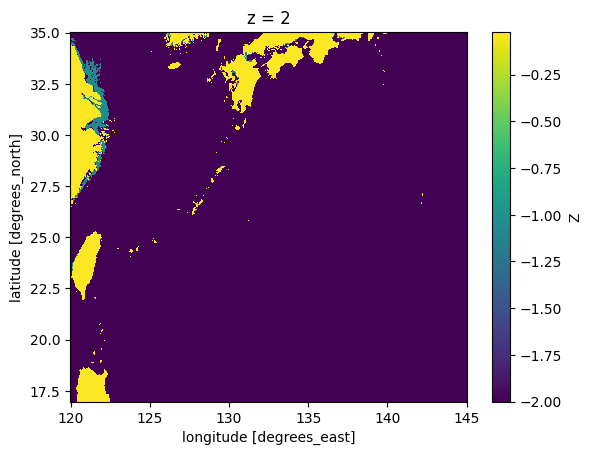

In [2]:
ds_sbasic.Z.isel(z=1).plot()

Now we have converted the sbasic into xarray.dataset we have Z , ZZ (layers thickness), DZ 

zlev(kzd) →  layer centers

z_z(kzd+1) → depths of the interfaces.

dz_z(kzd) → vertical thickness of layers.

## Now we need to convert some binaries files in order to get them as xarray

In [14]:
from download_bin import fetch_hourly_and_decompress


output_base_dir = Path("/mnt/c/Users/ecap/Documents/JCOPE/BIN_DOWNLOAD/")

# URL du dossier distant 
base_url = "https://www.jamstec.go.jp/jcope/data/odaka20240424-2102"

# Date de départ 
start_time = "202102220000"
n_time = 2
# overwrite=False évite de retélécharger / regunzipper si déjà présent
overwrite_downloads = False

# strict=True lèvera une erreur si on n'a pas trouvé exactement n_time fichiers
strict_mode = True
# ---------------------------------------------------------

egtdir_new = output_base_dir / "EGT"
ttdir_new  = output_base_dir / "TT"

fetch_hourly_and_decompress("EGT", base_url, start_time, n_time, egtdir_new,
                            overwrite=overwrite_downloads, strict=strict_mode)
fetch_hourly_and_decompress("TT",  base_url, start_time, n_time, ttdir_new,
                            overwrite=overwrite_downloads, strict=strict_mode)

egtdir = egtdir_new
ttdir  = ttdir_new

-> EGT_202102220000.bin.gz exists, skip download
-> EGT_202102220000.bin exists, skip gunzip
-> EGT_202102220100.bin.gz exists, skip download
-> EGT_202102220100.bin exists, skip gunzip
[OK] 2 fichiers .bin prêts dans /mnt/c/Users/ecap/Documents/JCOPE/BIN_DOWNLOAD/EGT
-> TT_202102220000.bin.gz exists, skip download
-> TT_202102220000.bin exists, skip gunzip
Downloading: https://www.jamstec.go.jp/jcope/data/odaka20240424-2102/TT_202102220100.bin.gz
Decompressing TT_202102220100.bin.gz -> TT_202102220100.bin
[OK] 2 fichiers .bin prêts dans /mnt/c/Users/ecap/Documents/JCOPE/BIN_DOWNLOAD/TT


In [15]:

from pathlib import Path
import numpy as np
import xarray as xr

egt_ctl = egtdir.parent / "CTL/EGT_patch_zdef1.ctl"


tt_ctl = ttdir.parent / "CTL/TT.ctl"

out_path = ttdir / "EGT_TT_first10.zarr"
# -------------------

# Lire les n premiers pas de temps 
ds_egt = read_first_n_times(egtdir, egt_ctl, "EGT_*.bin", n=n_time)
ds_tt  = read_first_n_times(ttdir, tt_ctl, "TT_*.bin", n=n_time)

ds_combined_ssh_tt = xr.merge([ds_egt, ds_tt])
ds_combined_ssh_tt = ds_combined_ssh_tt.rename({"x": "longitude", "y": "latitude", "sigma": "z"})
# Écriture
print(f"Ecriture du NetCDF : {out_path}")
ds_combined_ssh_tt.to_zarr(out_path,mode='w')
print("[OK] Fichier écrit :", out_path)
ds_combined_ssh_tt

Reading EGT_202102220000.bin
Reading EGT_202102220100.bin
Reading TT_202102220000.bin
Reading TT_202102220100.bin
Ecriture du NetCDF : /mnt/c/Users/ecap/Documents/JCOPE/BIN_DOWNLOAD/TT/EGT_TT_first10.zarr
[OK] Fichier écrit : /mnt/c/Users/ecap/Documents/JCOPE/BIN_DOWNLOAD/TT/EGT_TT_first10.zarr


/home/ecap/micromamba/envs/pangeo-fish_debug/lib/python3.11/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


<xarray.Dataset> Size: 225MB
Dimensions:    (latitude: 650, longitude: 902, time: 2, z: 47)
Coordinates:
  * latitude   (latitude) float32 3kB 16.99 17.01 17.04 ... 34.96 34.99 35.01
  * longitude  (longitude) float32 4kB 120.0 120.0 120.0 ... 145.0 145.0 145.0
  * time       (time) datetime64[ns] 16B 2021-02-22 2021-02-22T01:00:00
  * z          (z) float32 188B 1.0 2.0 3.0 4.0 5.0 ... 43.0 44.0 45.0 46.0 47.0
Data variables:
    el         (time, latitude, longitude) float32 5MB 0.2286 0.2305 ... 1.014
    t          (time, z, latitude, longitude) float32 220MB 26.25 26.23 ... nan
Attributes:
    title:    el first 2 times concatenated from GrADS binaries
    history:  time coordinate set from filename

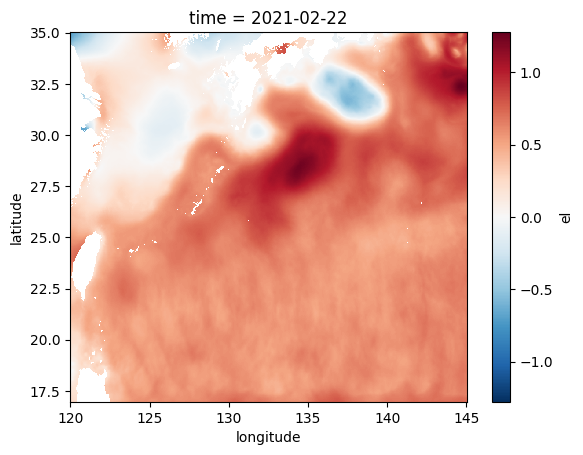

In [17]:
ds_combined_ssh_tt.el.isel(time=0).plot()

Here **I spot a problem** there is a very small diff between both lon/lat 

Trick to avoid the differences between both latitudes/longitudes 

In [18]:
ds_sbasic = ds_sbasic.assign_coords(
    longitude = ("longitude", ds_combined_ssh_tt.longitude.values),
    latitude  = ("latitude",  ds_combined_ssh_tt.latitude.values)
)
ds_sbasic

<xarray.Dataset> Size: 661MB
Dimensions:    (latitude: 650, longitude: 902, z: 47, zlev: 47)
Coordinates:
  * z          (z) int32 188B 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46 47
  * zlev       (zlev) float64 376B -2.5 -7.5 -12.5 ... -1.45e+03 -1.55e+03
  * longitude  (longitude) float32 4kB 120.0 120.0 120.0 ... 145.0 145.0 145.0
  * latitude   (latitude) float32 3kB 16.99 17.01 17.04 ... 34.96 34.99 35.01
Data variables:
    Z          (latitude, longitude, z) float64 220MB 0.0 -2.0 ... -5.803e+03
    ZZ         (latitude, longitude, z) float64 220MB -1.0 -3.5 ... -5.803e+03
    DZ         (latitude, longitude, z) float64 220MB 2.0 3.0 ... 269.0 269.0
Attributes: (12/13)
    title:                basic.dat (Z, ZZ, DZ) from a Fortran unformatted se...
    fortran_unformatted:  sequential
    endianness:           big-or-little (auto-detected)
    record_marker_bytes:  4
    fildsc:               runz
    im:                   902
    ...                   ...
    km:                   47
    dx:                   0.027777777777777776
    dy:                   0.027777777777777776
    xlons:                119.986111
    ylats:                16.986111
    ichflg_expected:      123456

Now that we have converted :

1. **sbasic.dat** to xarray ( z, zz, dz)
2. **binary conversion** , for some timesteps, from EGT_XXXXXXX ( --> SSH ) and TT_XXXXXXX ( ocean temperature by layers)

Now the purpose is to get from sigma coordinate (cf ds_combined_ssh_tt above using sigma) to depth in meters so we'll need :
1. Merge both xarray
2. interpolate the informations of the layer using sigma coordinate (Z , and ZZ) to finish with a "depth" coordinate in meters.   

In [23]:
#ds_combined_ssh_tt = ds_combined_ssh_tt.rename({"x": "longitude", "y": "latitude", "sigma": "z"}).assign_coords(z=lambda ds: ds["z"].astype(int))
#ds_merged = ds_sbasic.merge(ds_combined_ssh_tt.drop_vars(["longitude", "latitude"]))
ds_merged = ds_sbasic.merge(ds_combined_ssh_tt)
ds_merged

<xarray.Dataset> Size: 886MB
Dimensions:    (latitude: 650, longitude: 902, z: 47, zlev: 47, time: 2)
Coordinates:
  * z          (z) int32 188B 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46 47
  * zlev       (zlev) float64 376B -2.5 -7.5 -12.5 ... -1.45e+03 -1.55e+03
  * longitude  (longitude) float32 4kB 120.0 120.0 120.0 ... 145.0 145.0 145.0
  * latitude   (latitude) float32 3kB 16.99 17.01 17.04 ... 34.96 34.99 35.01
  * time       (time) datetime64[ns] 16B 2021-02-22 2021-02-22T01:00:00
Data variables:
    Z          (latitude, longitude, z) float64 220MB 0.0 -2.0 ... -5.803e+03
    ZZ         (latitude, longitude, z) float64 220MB -1.0 -3.5 ... -5.803e+03
    DZ         (latitude, longitude, z) float64 220MB 2.0 3.0 ... 269.0 269.0
    el         (time, latitude, longitude) float32 5MB 0.2286 0.2305 ... 1.014
    t          (time, z, latitude, longitude) float32 220MB 26.25 26.23 ... nan
Attributes: (12/13)
    title:                basic.dat (Z, ZZ, DZ) from a Fortran unformatted se...
    fortran_unformatted:  sequential
    endianness:           big-or-little (auto-detected)
    record_marker_bytes:  4
    fildsc:               runz
    im:                   902
    ...                   ...
    km:                   47
    dx:                   0.027777777777777776
    dy:                   0.027777777777777776
    xlons:                119.986111
    ylats:                16.986111
    ichflg_expected:      123456

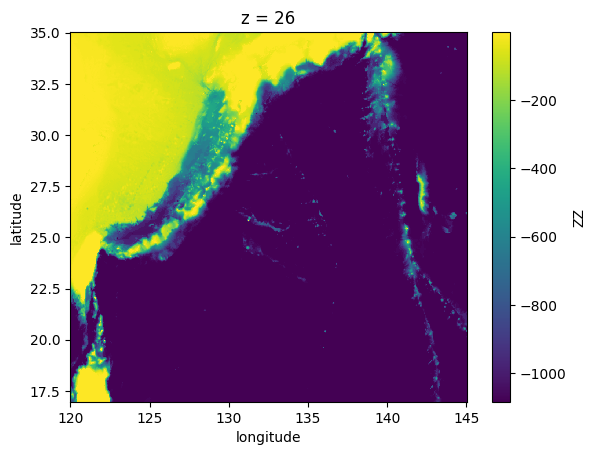

In [20]:
ds_merged.ZZ.isel(z=25).plot()

## Now we have merge the dataset with all the values that we gonna need we can interpolate the infos

In [47]:
from pathlib import Path
import requests
import xarray as xr

url = "https://www.jamstec.go.jp/jcope/data/odaka20240424-netcdf/TT_20210222.nc"
local = Path("/mnt/c/Users/ecap/Documents/JCOPE/TT_20210222.nc")

local.parent.mkdir(parents=True, exist_ok=True)


if not local.exists():
    print(f"Téléchargement {url} → {local}")
    r = requests.get(url)
    r.raise_for_status()
    with open(local, "wb") as f:
        f.write(r.content)
else:
    print(f"Fichier déjà présent : {local}")


ds_netcdf_reference = xr.open_dataset(local)
ds_netcdf_reference

Fichier déjà présent : /mnt/c/Users/ecap/Documents/JCOPE/TT_20210222.nc


<xarray.Dataset> Size: 4GB
Dimensions:  (time: 24, depth: 30, lat: 1190, lon: 1190)
Coordinates:
  * lon      (lon) float32 5kB 117.0 117.0 117.0 117.1 ... 150.0 150.0 150.0
  * lat      (lat) float32 5kB 16.99 17.01 17.04 17.07 ... 49.96 49.99 50.01
  * depth    (depth) float32 120B 0.0 5.0 10.0 20.0 ... 350.0 400.0 450.0 500.0
  * time     (time) datetime64[ns] 192B 2021-02-22 ... 2021-02-22T23:00:00
Data variables:
    TT       (time, depth, lat, lon) float32 4GB ...
Attributes:
    history:     2021-03-02 10:45 UTC : NetCDF Fortran90
    title:       Product name: JCOPE-T DA Near Real-Time Analysis
    references:  Version: v20180705.16
    comment:     Start date of running the model: 20210302

In [24]:
ds_from_bin = ds_merged

In [54]:
import time

time_vals = ds_from_bin['time'].values
depth_target_pos = - ds_netcdf_reference.depth.values
ny = ds_from_bin.dims['latitude']
nx = ds_from_bin.dims['longitude']
nt = ds_from_bin.dims['time']
nz_out = len(depth_target_pos)

# traiter uniquement les N premiers pas de temps (ou moins si nt<5)
nt_proc = min(2, nt)
print(f"[INFO] nt total = {nt}, nt_proc = {nt_proc}")

# Préallocation sur nt_proc (beaucoup plus petit que nt)
TLEV_all = np.full((nt_proc, ny, nx, nz_out), np.nan, dtype=np.float32)

total_start = time.time()
for it in range(nt_proc):
    step_start = time.time()
    print(f"[INFO] Début interpolation time step {it+1}/{nt_proc} (global step {it+1}/{nt})")
    
    # récupérer le champ t; on suppose shape (z, lat, lon) après isel(time=it)
    T0_t = ds_from_bin['t'].isel(time=it).values   # (z, lat, lon)
    T0_t = np.transpose(T0_t, (1, 2, 0))             # (lat, lon, z)

    # selecting with ssh or not 
    ssh = ds_from_bin['el'].isel(time=it).values   # shape (lat, lon)
    # ssh = np.zeros((ny, nx), dtype=np.float32)
    
    TLEV_all[it] = interp_sigma_to_zlev_with_ssh(
                                                T=T0_t,
                                                Z=None,                 # on ignore Z
                                                ZZ=ds_from_bin['ZZ'].values,
                                                ssh=ssh,
                                                zlev=depth_target_pos,  # tes profondeurs cibles
                                                grid_h=0,
                                                grid_z=0,               
                                                min_depth=1e-3
                                                )
    
    step_elapsed = time.time() - step_start
    total_elapsed_so_far = time.time() - total_start
    avg_per_step = total_elapsed_so_far / (it + 1)
    remaining_est = avg_per_step * (nt_proc - (it + 1))
    
    print(f"[INFO] Fin time step {it+1}/{nt_proc} en {step_elapsed:.2f} s — "
          f"cumul {total_elapsed_so_far:.2f} s — estimé restant {remaining_est:.2f} s")

total_elapsed = time.time() - total_start
print(f"[INFO] Traitement des {nt_proc} pas terminé en {total_elapsed:.2f} s")

# Conversion en xarray pour les nt_proc premiers pas
da = xr.DataArray(
    TLEV_all,
    dims=('time','latitude','longitude','depth'),
    coords={
        'time': time_vals[:nt_proc],
        'latitude': ds_from_bin.latitude.values,
        'longitude': ds_from_bin.longitude.values,
        'depth': -depth_target_pos
    },
    name='t_on_depth'
)
ds_out = da.to_dataset(name='t_on_depth')
ds_out

/tmp/ipykernel_2389/1552359983.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ny = ds_from_bin.dims['latitude']
/tmp/ipykernel_2389/1552359983.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nx = ds_from_bin.dims['longitude']
/tmp/ipykernel_2389/1552359983.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nt = ds_from_bin.dims['time']


[INFO] nt total = 2, nt_proc = 2
[INFO] Début interpolation time step 1/2 (global step 1/2)
Starting interpolation...
Progress: 0/650 rows
Progress: 65/650 rows
Progress: 130/650 rows
Progress: 195/650 rows
Progress: 260/650 rows
Progress: 325/650 rows
Progress: 390/650 rows
Progress: 455/650 rows
Progress: 520/650 rows
Progress: 585/650 rows
Interpolation complete.
[INFO] Fin time step 1/2 en 177.59 s — cumul 177.59 s — estimé restant 177.59 s
[INFO] Début interpolation time step 2/2 (global step 2/2)
Starting interpolation...
Progress: 0/650 rows
Progress: 65/650 rows
Progress: 130/650 rows
Progress: 195/650 rows
Progress: 260/650 rows
Progress: 325/650 rows
Progress: 390/650 rows
Progress: 455/650 rows
Progress: 520/650 rows
Progress: 585/650 rows
Interpolation complete.
[INFO] Fin time step 2/2 en 180.78 s — cumul 358.36 s — estimé restant 0.00 s
[INFO] Traitement des 2 pas terminé en 358.36 s


<xarray.Dataset> Size: 141MB
Dimensions:     (time: 2, latitude: 650, longitude: 902, depth: 30)
Coordinates:
  * time        (time) datetime64[ns] 16B 2021-02-22 2021-02-22T01:00:00
  * latitude    (latitude) float32 3kB 16.99 17.01 17.04 ... 34.96 34.99 35.01
  * longitude   (longitude) float32 4kB 120.0 120.0 120.0 ... 145.0 145.0 145.0
  * depth       (depth) float32 120B 0.0 5.0 10.0 20.0 ... 400.0 450.0 500.0
Data variables:
    t_on_depth  (time, latitude, longitude, depth) float32 141MB 26.25 ... 15.32

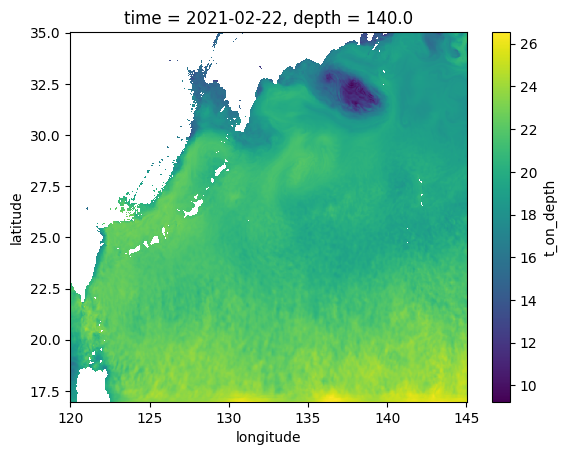

In [55]:
ds_out.t_on_depth.isel(time=0,depth=15).plot()

## Now we can check the diff between reference netcdf and the one we just interpolated

In [56]:
ds_reduit_netcdf_great = ds_netcdf_reference.sel(
    lat=slice(20, 34),
    lon=slice(125, 140)
)
ds_out_reduit = ds_out.sel(
    latitude=slice(20, 34),
    longitude=slice(125, 140)
)

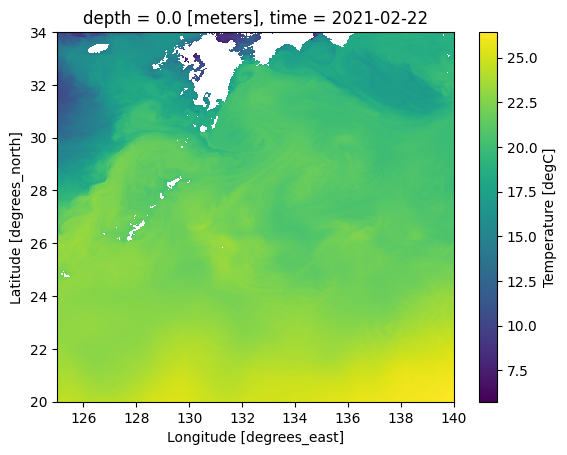

In [57]:
ds_reduit_netcdf_great.TT.isel(time=0,depth=0).plot()

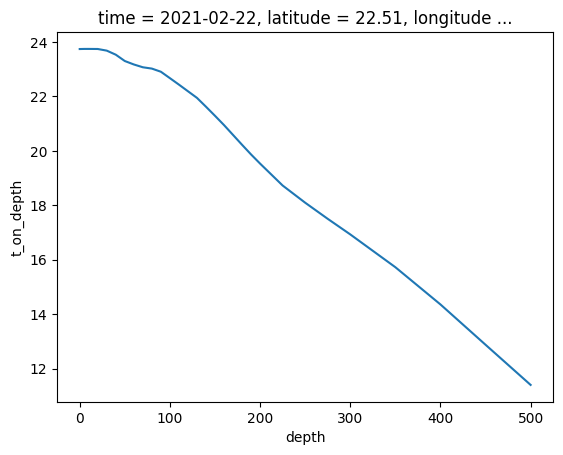

In [58]:
ds_out_reduit.t_on_depth.isel(time=0).sel(latitude=22.5,longitude=130,method='nearest').plot()

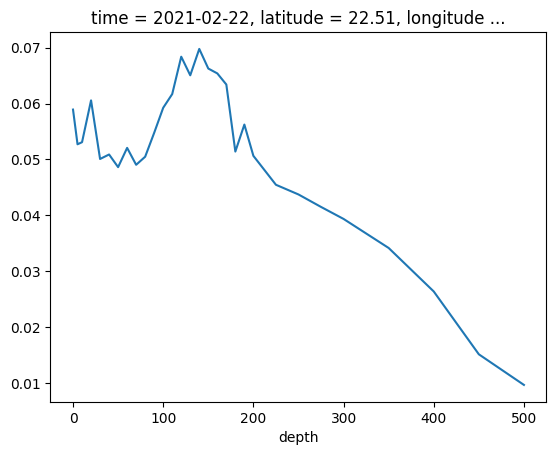

In [59]:
(ds_out_reduit.t_on_depth.isel(time=0).sel(latitude=22.5,longitude=130,method='nearest') - ds_reduit_netcdf_great.TT.sel(time='2021-02-22T00:00:00.000000000',lat=22.5,lon=130,method='nearest')).plot()